# BVA Citation: Preliminary Analysis

Author: Hongyi Zhang

Extract citations for single-issue cases and analyze their trends.

## Setup

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# install Google cloud storage FUSE to mount GCP buckets on colab
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!mkdir /bva-data
!gcsfuse bva-prediction-data /bva-data  # caution on write and/or delete

In [21]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import locale
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

## Connect to MongoDB

Database credentials are in `db_config.py` stored in the GCP bucket to ensure security.

In [13]:
import pymongo
import os
os.chdir('/bva-data/')
from db_config import *

# connect to mongo database
db = pymongo.MongoClient(host=DB_HOST, port=DB_PORT)[DB_DATABASE]
db.authenticate(DB_USER, DB_PASSWORD)

True

In [9]:
# example document structure
db.documents.find_one()

{'_id': 'bva-1-0410326',
 'bva_id': '0410326',
 'coll': 'bva',
 'sentence_bounds': [[0, 20],
  [23, 46],
  [50, 72],
  [76, 97],
  [100, 104],
  [116, 211],
  [217, 227],
  [231, 233],
  [235, 305],
  [309, 311],
  [313, 363],
  [367, 369],
  [371, 430],
  [434, 436],
  [438, 485],
  [489, 491],
  [493, 591],
  [595, 597],
  [599, 695],
  [701, 715],
  [719, 764],
  [770, 792],
  [796, 824],
  [830, 842],
  [846, 959],
  [965, 1166],
  [1169, 1189],
  [1195, 1257],
  [1260, 1287],
  [1289, 1422],
  [1424, 1545],
  [1547, 1608],
  [1612, 1756],
  [1758, 1831],
  [1839, 1845],
  [1849, 2013],
  [2015, 2099],
  [2101, 2222],
  [2224, 2382],
  [2388, 2620],
  [2622, 2858],
  [2864, 3017],
  [3019, 3187],
  [3190, 3196],
  [3198, 3433],
  [3439, 3555],
  [3557, 3629],
  [3631, 3957],
  [3959, 4064],
  [4066, 4101],
  [4104, 4129],
  [4135, 4274],
  [4276, 4311],
  [4313, 4495],
  [4497, 4734],
  [4736, 4783],
  [4786, 4834],
  [4836, 5123],
  [5127, 5252],
  [5256, 5258],
  [5260, 5713],
  

In [10]:
# total number of documents
db.documents.estimated_document_count()

1024074

In [11]:
# example metadata structure
db.appeals_meta.find_one()

{'_id': ObjectId('5c5fbc787b52b91af067a3ef'),
 'appeal_id': '715766',
 'appealed_CAVC': '0',
 'cvdisp': '',
 'cvdocket': '',
 'imgadtm': '1998-06-11',
 'isscode': '2',
 'issdc': '3',
 'isslev2': 'NA',
 'isslev3': 'NA',
 'issprog': '6',
 'issseq': '1',
 'issue_count': '1',
 'issue_id': '715766-1-1',
 'tiread2': '9818139'}

In [16]:
# filter single issue cases
single_issue_ids = pd.DataFrame(list(db.appeals_meta.find(
    {"issue_count": "1"},       # find single issue cases
    {"_id": 0, "tiread2": 1}    # we only want their IDs
)))
single_issue_ids

,tiread2
0,9818139
1,9906382
2,9909951
3,9913182
4,9933622
...,...
347032,1743393
347033,1743298
347034,1743859
347035,1743379


## Extract citations for single issue cases

Citation extraction code gives credit to Mark Krass.

No need to run this part again since I have already written the data to the database `db.single_citations`.

In [0]:
# Build a pattern to extract case and statute citations
# Author: Mark Krass
case_patt = re.compile('(See\s|See,\se\.g\.,\s|See\salso|)([DeMcO\'Mac]*[A-Z][a-z]+\s[A-Z]?[a-z]*\s?v\.\s[A-Z][a-z]+[,\s]+|)(\d{1,4})\s(F.2d|F.3d|F.|Vet. App.|U.S.|F. Supp.|F.Supp.|F. Supp. 2d|F. Supp. 3d|F.Supp.2d|F.Supp.3d|F. Supp. 2d.|F. Supp. 3d.)(\s|\sat\s)(\d{1,4})[,\s]*(\d{1,4}[,\-\s]*\d*|)[,\-\s]*(\d*|)(\s?\([A-Za-z\.\s]*\d{4}\)|)')
statute_patt = re.compile('([0-9]{1,4}\s)(C.F.R.|U.S.C.A.|U.S.C.|C. F. R.|U. S. C.| U. S. C. A.)\s[\\xa7]*\s*(\d{1,4}[\.,\s]*\d{1,4}[\(\)A-Za-z\d]*)([,\s\d]*)(\([A-Za-z\.\s]*\d{4}\)|)')

def match_citations(text):      # this one is new!
    """Remove \r, \n and replacement character to better match citations"""
    return re.findall(case_patt, text.replace('\r', '').replace('\n', '').replace('\ufffd', ''))

def citeparse(components): 
    """Given a case citation, label its constituent components"""
    components = [item.strip() for item in components]
    signal, caption, volume, reporter, s, startpage, pin1, pin2, year = components
    out = {
        'signal': signal,        # this is an indication of how the authority is being used
        'caption': caption,      # title of the cited case
        'volume': volume,        # volume of the book where the case is reported
        'reporter': reporter,    # case reporter
        'startpage': startpage,  # case start page in the reporter
        'pincites': [pin1,pin2], # specific reference in the reporter
        'yr': year, 
        'case': volume + ' ' + reporter + ' ' + startpage
    }
    return out

def statparse(components): 
    components = [item.strip() for item in components]
    vol, code, s1, s2, year = components
    # Turn the sections into a list of individual section numbers
    if s2 != '':
        ss = ', '.join([s1,s2]).split(', ')
    elif s2 == '':
        ss = s1.split(', ')
    ss = [x for x in ss if x is not '']
    # create a dict and count refs to each statute section
    out = {
        'statutes': [' '.join([vol, code, s]) for s in ss],
        'volume': vol,
        'code': code,
        'year': year,
        'sections': ss
    }
    return out

In [14]:
# test citeparse function
text = db.documents.find_one().get('txt')
matched_citations = match_citations(text)
list(map(citeparse, matched_citations))

[{'caption': 'Quartuccio v. Principi,',
  'case': '16 Vet. App. 183',
  'pincites': ['', ''],
  'reporter': 'Vet. App.',
  'signal': 'See',
  'startpage': '183',
  'volume': '16',
  'yr': '(2002)'},
 {'caption': 'Hyder v. Derwinski,',
  'case': '1 Vet. App. 221',
  'pincites': ['', ''],
  'reporter': 'Vet. App.',
  'signal': 'See',
  'startpage': '221',
  'volume': '1',
  'yr': '(1991)'},
 {'caption': 'Green v. Derwinski,',
  'case': '1 Vet. App. 121',
  'pincites': ['124', ''],
  'reporter': 'Vet. App.',
  'signal': '',
  'startpage': '121',
  'volume': '1',
  'yr': '(1991)'},
 {'caption': 'Quartuccio v. Principi,',
  'case': '16 Vet. App. 183',
  'pincites': ['', ''],
  'reporter': 'Vet. App.',
  'signal': '',
  'startpage': '183',
  'volume': '16',
  'yr': '(2002)'},
 {'caption': 'Charles v. Principi,',
  'case': '16 Vet. App. 370',
  'pincites': ['', ''],
  'reporter': 'Vet. App.',
  'signal': '',
  'startpage': '370',
  'volume': '16',
  'yr': '(2002)'},
 {'caption': 'Stegall v. W

In [0]:
# extract citations for each single-issue case
citation_list = []
single_issue_documents = db.documents.find(
    {"bva_id": {"$in": list(single_issue_ids.tiread2)}},
    {"_id": 0, "bva_id": 1, "txt": 1}
)

# iterate through all the document texts
# this might take up to 20 minutes
cnt = 0
for document in single_issue_documents:
    text = document.pop('txt')
    matched = match_citations(text)
    citations = {"citations": list(map(citeparse, matched))}
    citation_list.append({**document, **citations})
    cnt += 1
    if cnt % 1000 == 0:
        print("Finished {} documents".format(cnt))

In [22]:
# example citation structure
citation_list[0]

{'_id': ObjectId('5e72a9ecf5711eb611d38cfb'),
 'bva_id': '0000001',
 'citations': [{'caption': 'Littke v. Derwinski,',
   'case': '1 Vet. App. 90',
   'pincites': ['', ''],
   'reporter': 'Vet. App.',
   'signal': '',
   'startpage': '90',
   'volume': '1',
   'yr': '(1990)'},
  {'caption': 'Murincsak v. Derwinski,',
   'case': '2 Vet. App. 363',
   'pincites': ['', ''],
   'reporter': 'Vet. App.',
   'signal': '',
   'startpage': '363',
   'volume': '2',
   'yr': '(1992)'},
  {'caption': 'Green v. Derwinski,',
   'case': '1 Vet. App. 121',
   'pincites': ['', ''],
   'reporter': 'Vet. App.',
   'signal': '',
   'startpage': '121',
   'volume': '1',
   'yr': '(1991)'},
  {'caption': 'Bell v. Derwinski,',
   'case': '2 Vet. App. 611',
   'pincites': ['', ''],
   'reporter': 'Vet. App.',
   'signal': '',
   'startpage': '611',
   'volume': '2',
   'yr': '(1992)'},
  {'caption': 'Quarles v. Derwinski,',
   'case': '3 Vet. App. 129',
   'pincites': ['141', ''],
   'reporter': 'Vet. App.',


In [20]:
# insert citations into database
db.single_citations.insert_many(citation_list)

In [21]:
# create an index on the collection
db.single_citations.create_index("bva_id")

'bva_id_1'

## Four particular citations to consider

For each particular citation, we use the `case` field to match cases that contain this citation as it is more robust compared to `caption`.

In [0]:
def find_cases_that_cite(citation):
    """
    Given a citation, finds information for all cases that contain that citation
    @input: a dict conforming to the agreed citation schema
    @output: a pandas dataframe that contains for each case that has the citation
            id, timestamp (UTC), whether appealed and CAVC disposition code
    """
    df = pd.DataFrame(list(db.single_citations.aggregate([{
        '$match': {'citations': {'$elemMatch': citation}}
    }, {
        '$lookup': {
            'from': "appeals_meta", 
            'localField': "bva_id", 
            'foreignField': "tiread2",
            'as': "metas"
        }
    }, {
        "$unwind": "$metas"
    }, {
        '$project': {
            '_id' : 0,
            'bva_id': 1,
            'timestamp': '$metas.imgadtm',
            'appealed_CAVC': '$metas.appealed_CAVC',
            'cvdisp': '$metas.cvdisp'
        }
    }])))

    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
        df['appealed_CAVC'] = df['appealed_CAVC'].astype(int)
        df['cvdisp'] = df['cvdisp']
    return df

In [212]:
# citation 1: Thun v. Peake (run takes ~10 seconds)
thun_v_peake = {
    'case': '22 Vet. App. 111',
}
cases = find_cases_that_cite(thun_v_peake)
cases

,bva_id,timestamp,appealed_CAVC,cvdisp
0,0820320,2008-06-18 00:00:00+00:00,0,
1,0821376,2008-06-30 00:00:00+00:00,0,
2,0822332,2008-07-07 00:00:00+00:00,0,
3,0822478,2008-07-08 00:00:00+00:00,0,
4,0822566,2008-07-09 00:00:00+00:00,0,
...,...,...,...,...
13311,1743227,2017-09-28 00:00:00+00:00,0,
13312,1743317,2017-09-27 00:00:00+00:00,0,
13313,1743383,2017-09-27 00:00:00+00:00,0,
13314,1743668,2017-09-28 00:00:00+00:00,0,


In [133]:
# describe the appeal destribution
cases.appealed_CAVC.value_counts()

0    11820
1     1496
Name: appealed_CAVC, dtype: int64

Now it's time to incorporate all the citations we would like to investigate into.

- Thun v. Peake, 22 Vet. App. 111 (2008)
    - Case date: April 23, 2008. It became near-ubiquitous in increased rating (IR) claims eventually. Its use then plummeted following a Board training conducted in August 2017, which advised against its use.
- Scott v. McDonald, 789 F.3d 1375 (Fed. Cir. 2015)
    - Case date: June 18, 2015. It slowly started to gain traction with the Board, resulting in me issuing guidance on how to approach it twice. Those guidance emails were dated July 31, 2017, and December 8, 2017. I also gave a training to judges which discussed proper use of Scott in May 2017 (precise day unknown). This may be an example of a slow uptake case, which then accelerated at some point in 2016 or 2017.
- Johnson v. McDonald, 762 F.3d 1362 (Fed. Cir. 2014)
    - Case date: August 6, 2014. This is an interesting case that for a time became a companion case (and cite) to Thun. However, it was on a slightly different aspect of the regulation, and therefore stood independently. This case would be interesting to examine as Thun was already in heavy use by the time Johnson came around, and so it may have been taken up more quickly just due to general awareness of Thun. However, the regulation that was the basis of Johnson was changed effective December 8, 2017, effectively eliminating Johnson. So, an analysis of Johnson would also look to the speed of the decline in citations to it following the reg change.
- Saunders v. Wilkie, 886 F.3d 1356 (2018) \[Omitted since we only have data up to 2017/09\]
    - Case date: April 3, 2018. While a major case in its own right, Saunders is notable for explicitly overruling Sanchez-Benitez v. West, 13 Vet. App. 282 (1999). Sanchez-Benitez was a widely cited case for a certain proposition, so one thing to look for is how fast citations to Sanchez-Benitez stop after the release of Saunders.


In [0]:
citation_set = {
    'Thun v. Peake': {'case': '22 Vet. App. 111'},
    'Scott v. McDonald': {'case': '789 F.3d 1375'},
    'Johnson v. McDonald': {'case': '762 F.3d 1362'},
    # 'Saunders v. Wilkie': {'case': '886 F.3d 1356'},
    # 'Sanchez-Benitez v. West': {'case': '13 Vet. App. 282'},
    'Overall': {}
}

# this may take ~1 minute due to large number of documents in Overall
cases_set = { citation: find_cases_that_cite(citation_description)
              for citation, citation_description in citation_set.items() }

Number of cases that cite Thun v. Peake: 13316
Number of cases that cite Scott v. McDonald: 3840
Number of cases that cite Johnson v. McDonald: 2327
Number of cases that cite Overall: 333644


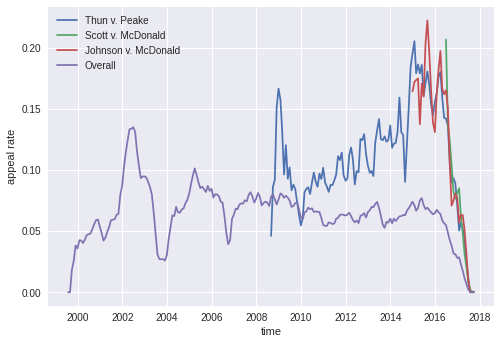

In [22]:
# monthly appeal rate (with sliding window of width 3)
plt.style.use('seaborn')

for citation in citation_set.keys():
    df = cases_set.get(citation)
    print("Number of cases that cite {}: {}".format(citation, len(df)))
    if df.empty: continue
    appeal_rates = df.groupby(pd.Grouper(key='timestamp', freq='M')).appealed_CAVC.mean()
    appeal_rates = appeal_rates.rolling(3).mean()
    plt.plot(appeal_rates.index, appeal_rates.values, label=citation)

plt.xlabel('time')
plt.ylabel('appeal rate')
plt.legend()

In [0]:
# CAVC disposition codes and labels
disp_codes = ['1', '5', '6', '7', '8', '9', '0', 'D', 'N', '2']
disp_labels = [
    '1 – Affirmed',
    '5 – Dismissed',
    '6 – Reversed',
    '7 – Vacated and Dismissed',
    '8 – Vacated and Remanded',
    '9 – Settlement',
    '0 – Abandoned',
    'D – Dismissed Death',
    'N – Not Appealed',
    '2 – Unknown'
]

In [0]:
# CAVC disposition distribution among all appealed cases that contain the citation
def plot_cavc_disposition_over_time(citation, code_to_plot='all'):
    cases = cases_set.get(citation)
    appealed_cases = cases[cases.appealed_CAVC == 1]

    group_by_time = appealed_cases.groupby(pd.Grouper(key='timestamp', freq='Q'))
    cvdisp_count = pd.DataFrame(0, index=group_by_time.groups.keys(), columns=disp_codes)
    for time, group in group_by_time:
        counts = group.cvdisp.value_counts(normalize=True)
        for code, count in counts.iteritems():
            cvdisp_count.loc[time, code] += count

    if code_to_plot != 'all':
        plt.plot(cvdisp_count.index, cvdisp_count[code_to_plot].values, label=citation)
        code_plotted = [label for label in disp_labels if label.startswith(code_to_plot)][0]
        plt.legend()
    else:
        plt.stackplot(cvdisp_count.index,
                    [ cvdisp_count[code].values for code in disp_codes ],
                    labels=disp_labels)
        code_plotted = "CAVC dispositions ({})".format(citation)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 0.5), loc="center")

    plt.xlabel('year')
    plt.ylabel('proportion')
    plt.title('Proportion of {} on a quarterly basis'.format(code_plotted))

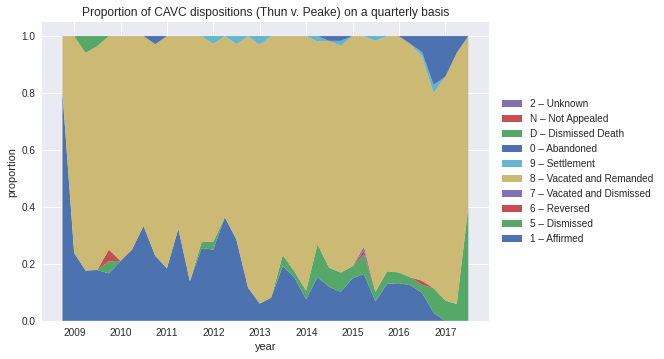

In [32]:
plot_cavc_disposition_over_time('Thun v. Peake')

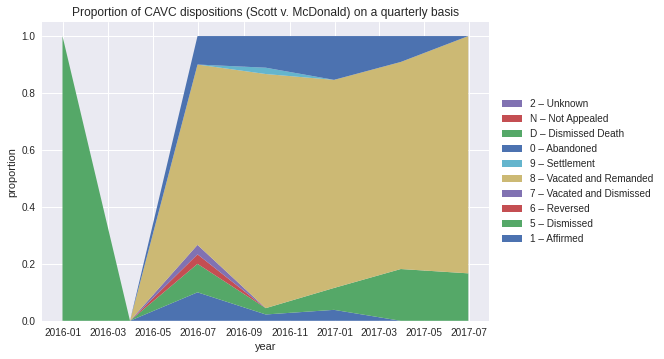

In [33]:
plot_cavc_disposition_over_time('Scott v. McDonald')

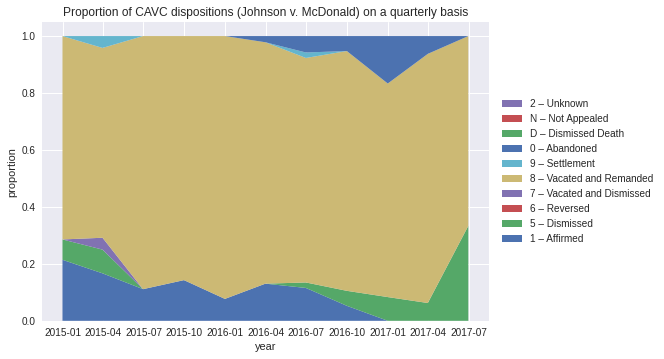

In [34]:
plot_cavc_disposition_over_time('Johnson v. McDonald')

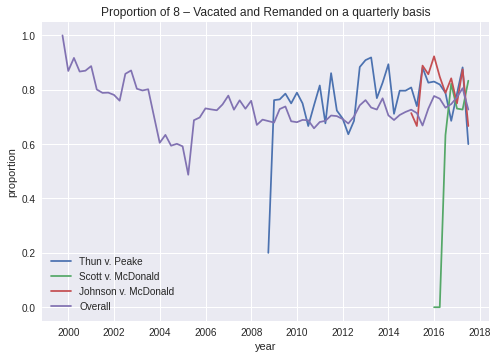

In [30]:
for citation in citation_set.keys():
    plot_cavc_disposition_over_time(citation, code_to_plot='8')